# Start work

In [ ]:
import pandas as pd
import zipfile
from datetime import datetime
import numpy as np
from tqdm import tqdm
from scipy.signal import convolve2d
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import lightgbm as lgb
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.metrics import BinaryAccuracy, Recall, Precision
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, roc_auc_score, roc_curve

### Load Data

In [ ]:
#load zip file
zf = zipfile.ZipFile('data.zip')

In [ ]:
#load train data
df_wafers = pd.read_csv(zf.open('wafers_train.csv'))
df_wafers.head()

,WaferName,DieX,DieY,IsGoodDie,IsScratchDie
0,8PFrAN,0,27,True,False
1,8PFrAN,0,28,True,False
2,8PFrAN,0,29,True,False
3,8PFrAN,0,30,True,False
4,8PFrAN,0,31,True,False


In [ ]:
#load test data
df_wafers_test = pd.read_csv(zf.open('wafers_test.csv'))
df_wafers_test.head()

,WaferName,DieX,DieY,IsGoodDie
0,mZa9ls,0,23,True
1,mZa9ls,0,24,True
2,mZa9ls,0,25,True
3,mZa9ls,0,26,True
4,mZa9ls,0,27,True


You can draw the wafers map to see how the wafers look like in the data.

Using the following helper function you can draw the wafer maps with or without labels:

In [ ]:
def plot_wafer_maps(wafer_df_list, figsize, labels = True):
    """
    plot wafer maps for list of df of wafers

    :param wafer_df_list: list, The list of df's of the wafers
    :param figsize: int, the size of the figsize height
    :param labels: bool, Whether to show the layer of labels (based on column 'IsScratchDie')

    :return: None
    """
    def plot_wafer_map(wafer_df, ax, map_type):
        wafer_size = len(wafer_df)
        s = 2**17/(wafer_size)
        if map_type == 'Label':
            mes = 'Scratch Wafer' if (wafer_df['IsScratchDie'] == True).sum()>0 else 'Non-Scratch Wafer'
        else:
            mes = 'Yield: ' + str(round((wafer_df['IsGoodDie']).sum()/(wafer_df['IsGoodDie']).count(), 2))

        ax.set_title(f'{map_type} | Wafer Name: {wafer_df["WaferName"].iloc[0]}, \nSum: {len(wafer_df)} dies. {mes}', fontsize=20)
        ax.scatter(wafer_df['DieX'], wafer_df['DieY'], color = 'green', marker='s', s = s)

        bad_bins = wafer_df.loc[wafer_df['IsGoodDie'] == False]
        ax.scatter(bad_bins['DieX'], bad_bins['DieY'], color = 'red', marker='s', s = s)

        if map_type == 'Label':
            scratch_bins = wafer_df.loc[(wafer_df['IsScratchDie'] == True) & (wafer_df['IsGoodDie'] == False)]
            ax.scatter(scratch_bins['DieX'], scratch_bins['DieY'], color = 'blue', marker='s', s = s)

            ink_bins = wafer_df.loc[(wafer_df['IsScratchDie'] == True) & (wafer_df['IsGoodDie'] == True)]
            ax.scatter(ink_bins['DieX'], ink_bins['DieY'], color = 'yellow', marker='s', s = s)

            ax.legend(['Good Die', 'Bad Die', 'Scratch Die', 'Ink Die'], fontsize=8)
        else:
            ax.legend(['Good Die', 'Bad Die'], fontsize=8)

        ax.axes.get_xaxis().set_visible(False)
        ax.axes.get_yaxis().set_visible(False)

    import numpy as np
    import matplotlib.pyplot as plt

    if labels:
        if len(wafer_df_list) > 1:
            fig, ax = plt.subplots(2, len(wafer_df_list), figsize=(figsize * len(wafer_df_list), figsize * 2))
            for idx1, wafer_df in enumerate(wafer_df_list):
                for idx2, map_type in enumerate(['Input', 'Label']):
                    plot_wafer_map(wafer_df, ax[idx2][idx1], map_type)
        else:  #had to change it a little so it will handle one wafer input
            fig, ax = plt.subplots(2, 1, figsize=(figsize, figsize * 2))
            plot_wafer_map(wafer_df_list[0], ax[0], 'Input')
            plot_wafer_map(wafer_df_list[0], ax[1], 'Label')
    else:
        fig, ax = plt.subplots(1, len(wafer_df_list), figsize=(figsize * len(wafer_df_list), figsize))
        for idx, wafer_df in enumerate(wafer_df_list):
            plot_wafer_map(wafer_df, ax[idx], 'Input')

    plt.show()

Select the amount of samples you want to display:

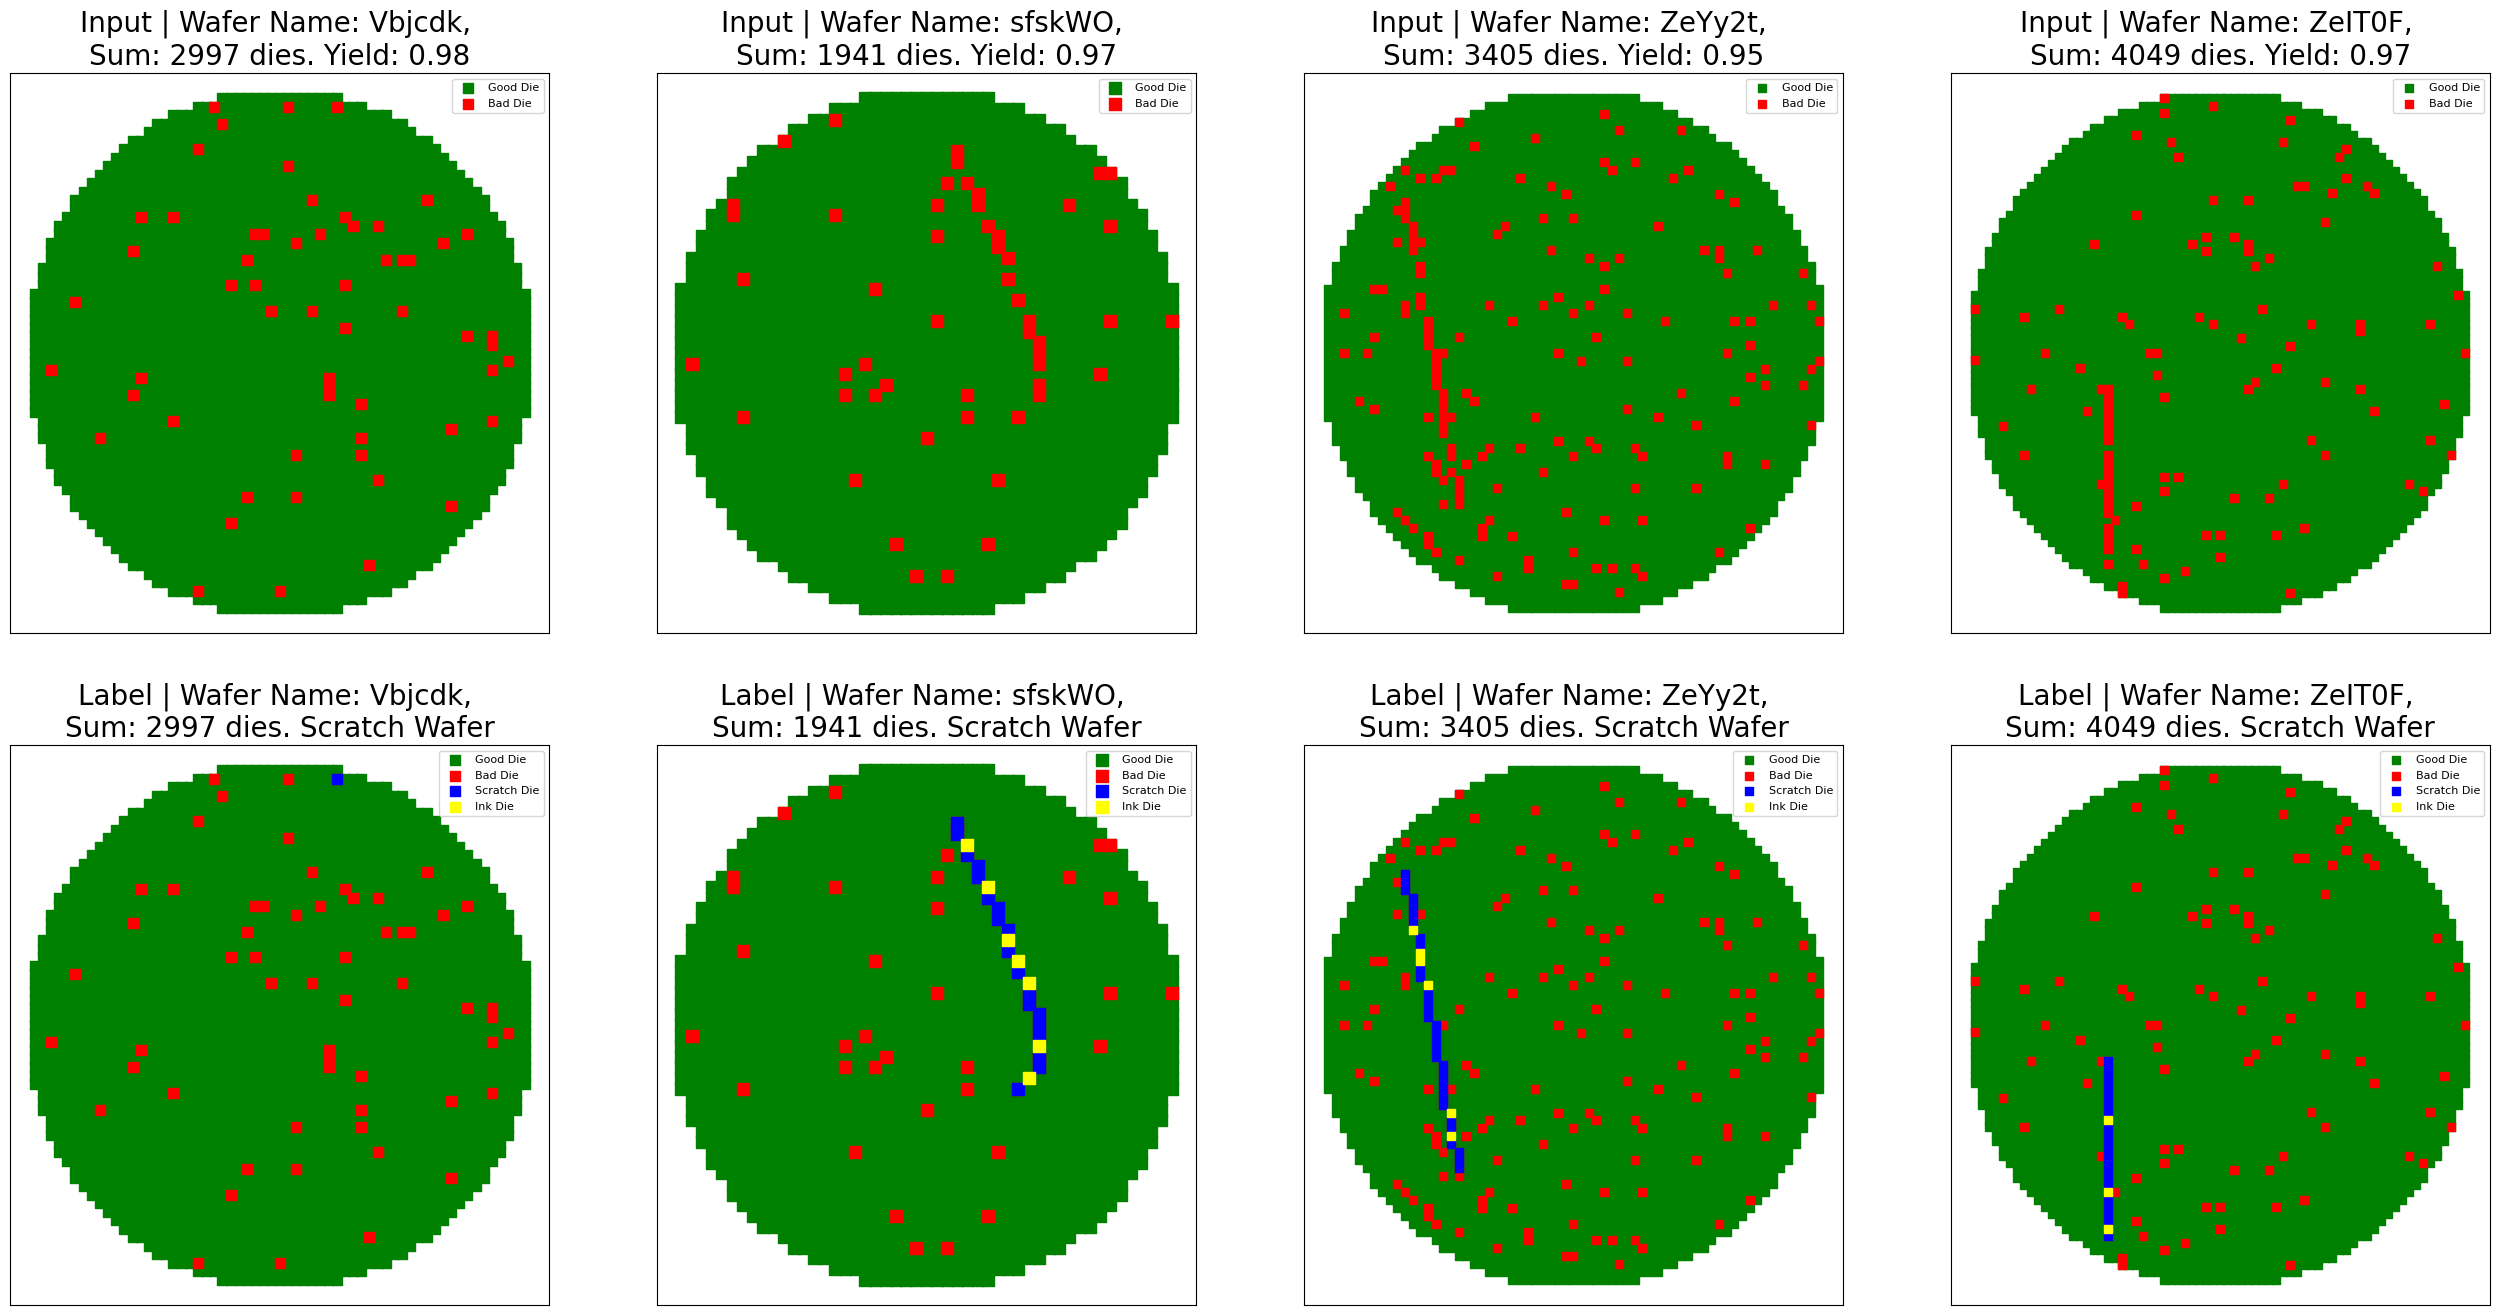

In [ ]:
n_samples = 4
list_sample_train = [df_wafers.groupby('WaferName').get_group(group) for group in df_wafers['WaferName'].value_counts().sample(n_samples, random_state=20).index]
plot_wafer_maps(list_sample_train, figsize = 8, labels = True)

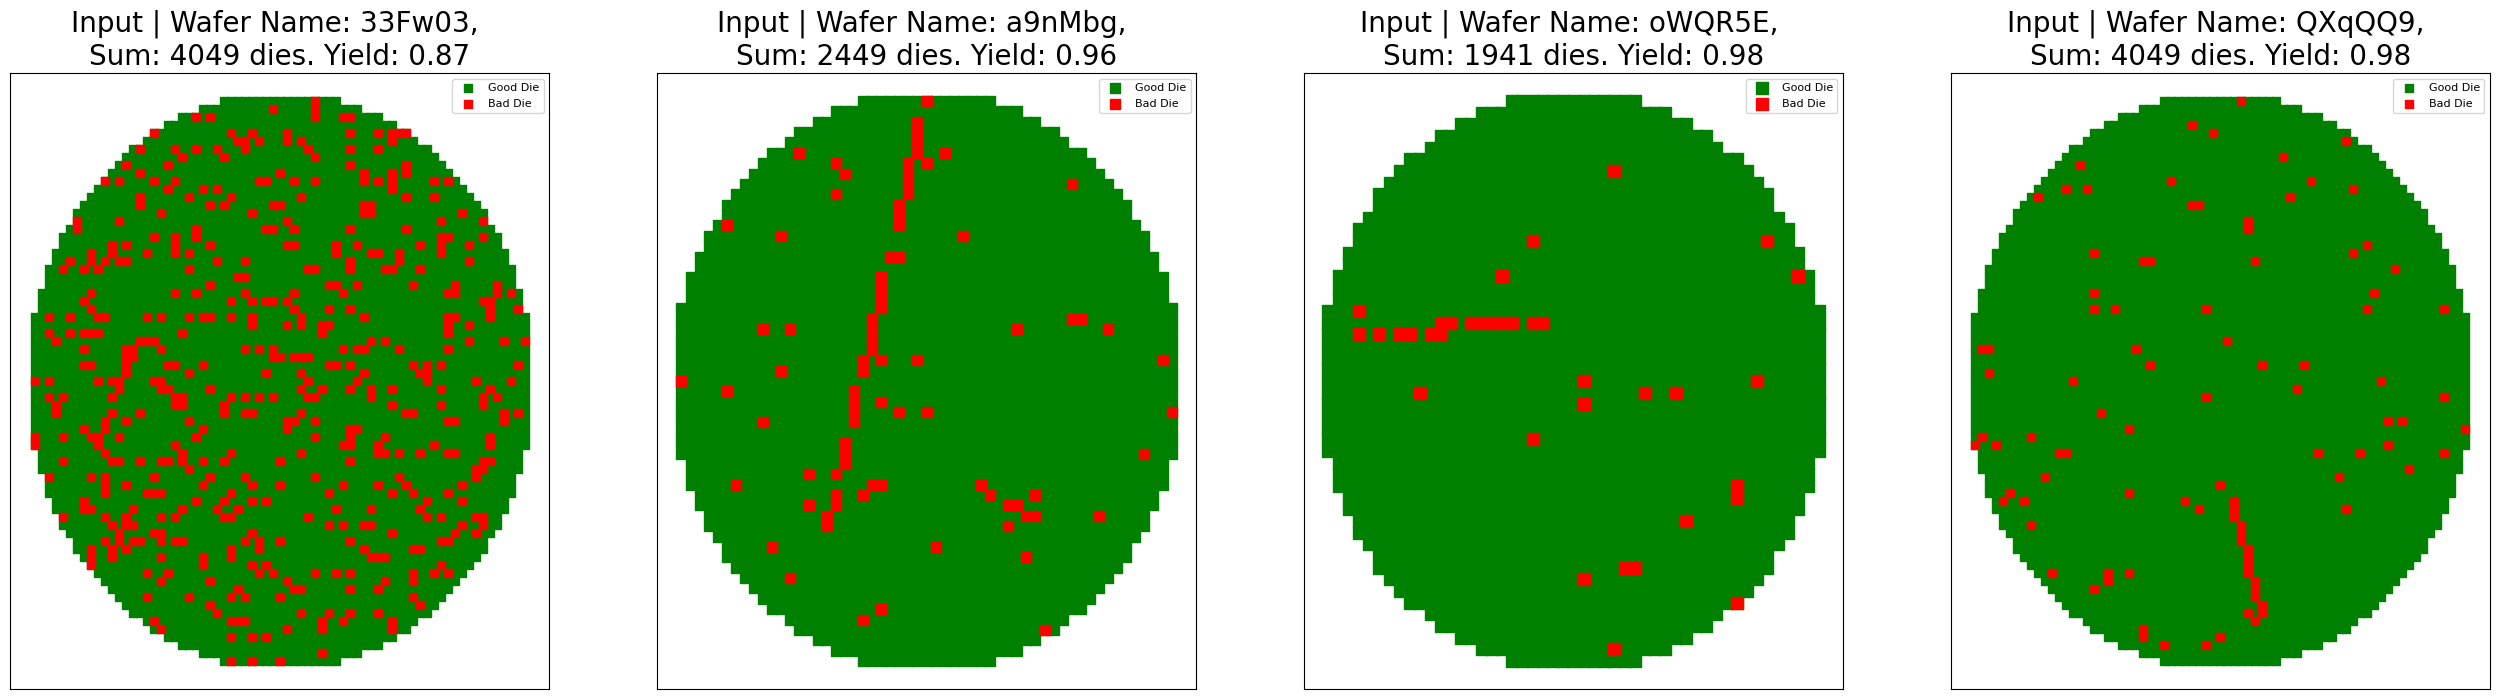

In [ ]:
list_sample_test = [df_wafers_test.groupby('WaferName').get_group(group) for group in df_wafers_test['WaferName'].value_counts().sample(n_samples, random_state=20).index]
plot_wafer_maps(list_sample_test, figsize = 8, labels = False)

# Build your solution

#  Data Exploration

In [ ]:
df_wafers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10415400 entries, 0 to 10415399
Data columns (total 5 columns):
 #   Column        Dtype 
---  ------        ----- 
 0   WaferName     object
 1   DieX          int64 
 2   DieY          int64 
 3   IsGoodDie     bool  
 4   IsScratchDie  bool  
dtypes: bool(2), int64(2), object(1)
memory usage: 258.3+ MB


In [ ]:
for i in df_wafers:
 print(df_wafers[i].value_counts())

WaferName
GHlqOp    4049
JXy6ur    4049
8PFrAN    4049
28I7Oi    4049
Vy557e    4049
          ... 
gwjgvf    1005
fHmbu6    1005
ef1Ztr    1005
yrg3GH    1005
5ANCVA    1005
Name: count, Length: 4200, dtype: int64
DieX
25    225000
24    225000
27    223800
26    223800
28    222600
       ...  
66     22200
67     19800
68     17400
69     13800
70     10200
Name: count, Length: 71, dtype: int64
DieY
24    225000
25    225000
27    223800
26    223800
21    222600
       ...  
66     22200
67     19800
68     17400
69     13800
70     10200
Name: count, Length: 71, dtype: int64
IsGoodDie
True     10036478
False      378922
Name: count, dtype: int64
IsScratchDie
False    10335081
True        80319
Name: count, dtype: int64


We can see that the number of Scratch Die is way less then Number of non Scartched Dies so our priamry tool to evaluate our model won't Be accuarcy and will be recall (tp/tp+fp) accuracy is expected to be very high

In [ ]:
wafers_with_scratches = df_wafers[df_wafers['IsScratchDie'] == True]['WaferName'].nunique()
print(f"Number of wafers with at least one scratch out of all wafers: {wafers_with_scratches}/{df_wafers['WaferName'].nunique()}")

Number of wafers with at least one scratch out of all wafers: 4073/4200


We can also see that most of the wafers have scratch on them

# Data analysis & Data Engineering


First i wanted to check if there is areas in the "wafer" that tend to be more "Scratchier"

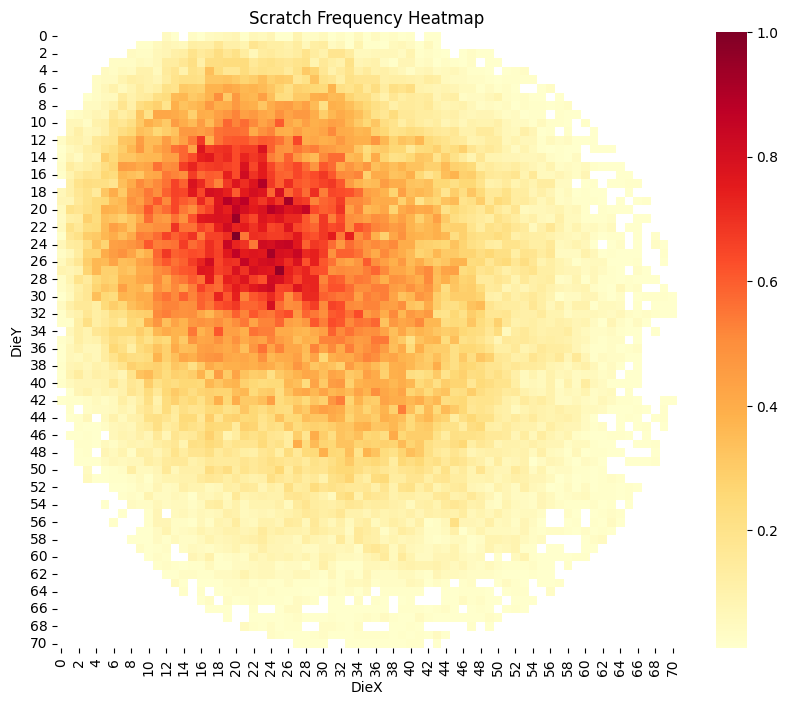

In [ ]:
def create_heatmap(df):
  """
  create and show Scratch frequency heatmap (scelared)

  Args:
  df (pandas.DataFrame): The input DataFrame containing the data.

  Returns:
  heatmap_data (pandas.DataFrame): The DataFrame containing the heatmap data.

  """
  heatmap_data = df[df['IsScratchDie'] == True].groupby(['DieX', 'DieY'])['WaferName'].count().reset_index()
  heatmap_data.rename(columns={'WaferName': 'ScratchScore'}, inplace=True)
  heatmap_data['ScratchScore'] = heatmap_data['ScratchScore'] / heatmap_data['ScratchScore'].max() ##normalize
  heatmap_pivot = heatmap_data.pivot(index="DieY", columns="DieX", values="ScratchScore")
  plt.figure(figsize=(10, 8))
  sns.heatmap(heatmap_pivot, cmap="YlOrRd", annot=False)
  plt.title("Scratch Frequency Heatmap")
  plt.xlabel("DieX")
  plt.ylabel("DieY")
  plt.show()
  return heatmap_data
heatmap_data = create_heatmap(df_wafers)

We can see that based on the data we have there is areas that tend to be more "scratchier" So we will add a "ScratchCount" column to our df

/tmp/ipython-input-1465891114.py:12: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_wafers['ScratchScore'].fillna(0, inplace=True)


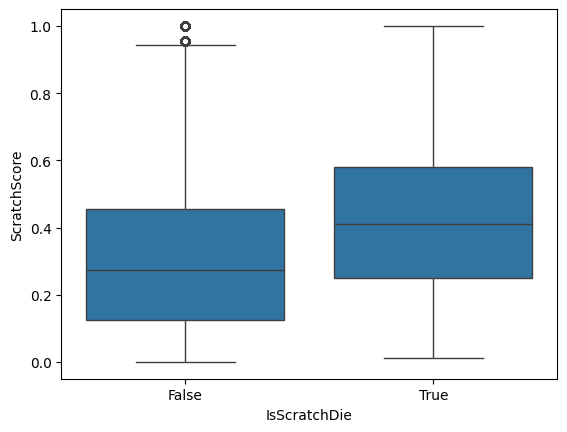

In [ ]:
def add_scratch_count(df_wafers):
  """
  add Scratch
  Args:
  df_wafers (pandas.DataFrame): The input DataFrame containing the data.

  Returns:
  df_wafers (pandas.DataFrame): The DataFrame containing the heatmap data.

  """
  df_wafers = pd.merge(df_wafers, heatmap_data, on=['DieX', 'DieY'], how='left')
  df_wafers['ScratchScore'].fillna(0, inplace=True)
  return df_wafers
df_wafers = add_scratch_count(df_wafers)

def create_boxplot(df_wafers):
  """
  create and show box plot of ScratchScore based on IsScratchDie

  Args:
  df_wafers (pandas.DataFrame): The input DataFrame containing the data.

  Returns:
  None

  """
  sns.boxplot(x=df_wafers["IsScratchDie"], y=df_wafers['ScratchScore'])
  plt.show()
create_boxplot(df_wafers)

Now i want to check if there is correlation between number of Bad Dies to The number of Scratches dies

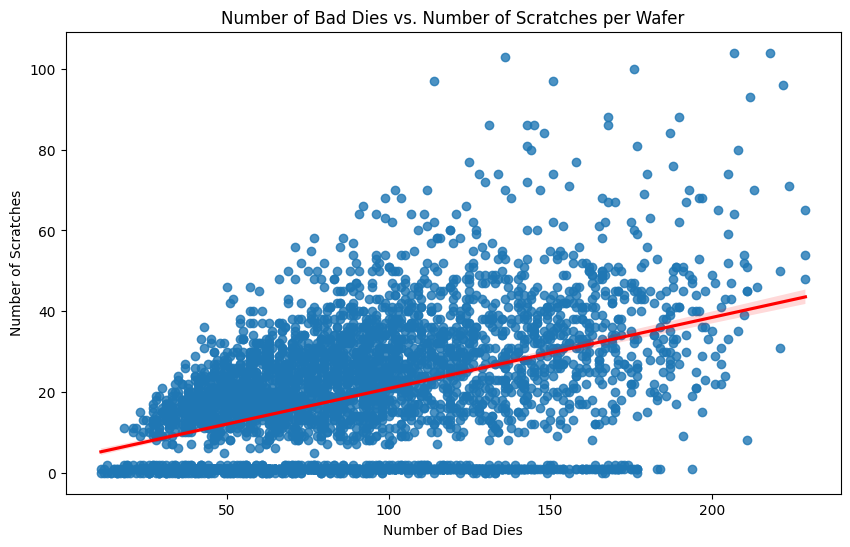

In [ ]:
def create_regplot(df_wafers):
  """
  create and show regression plot of ScratchScore based on IsGoodDie

  Args:
  df_wafers (pandas.DataFrame): The input DataFrame containing the data.

  Returns:
  None

  """
  wafer_stats = df_wafers.groupby('WaferName').agg(
      bad_dies=('IsGoodDie', lambda x: (x == False).sum()),
    scratches=('IsScratchDie', lambda x: (x == True).sum())
  ).reset_index()


# Create the scatter plot
  plt.figure(figsize=(10, 6))
  sns.regplot(x='bad_dies', y='scratches', data=wafer_stats, ci=95, line_kws={'color': 'red'})  # Added regression line and transparency
  plt.title('Number of Bad Dies vs. Number of Scratches per Wafer')
  plt.xlabel('Number of Bad Dies')
  plt.ylabel('Number of Scratches')
  plt.show()
create_regplot(df_wafers)

We can see that there is a correlation between Num of bad dies to the number of scratched dies so we will add a feature to each row giving a score (between 1 and 0) to the number of bad dies in the wafer (calculation will be NumOfBadDies/max(NumOfBadDies)

In [ ]:
def create_bad_die_score(df_wafers):
  """
  add a column Bad_die_Score to df_wafers

  Args:
  df_wafers (pandas.DataFrame): The input DataFrame containing the data.

  Returns:
  df_wafers (pandas.DataFrame): The DataFrame containing the data.

  """
  bad_counts = (~df_wafers['IsGoodDie']).groupby(df_wafers['WaferName']).sum()
  df_wafers['BadDieScore'] = df_wafers['WaferName'].map(bad_counts / bad_counts.max())
  return df_wafers
df_wafers = create_bad_die_score(df_wafers)



By looking at the wafer maps presented we can infer that bad dies are mostly continuous so we will create few features

HasBadNeighbor =>Is any Die adjacent to you is bad (Bool)

BadDieWithBadNeighbor => Is HasBadNeighbor True And IsGoodDie False (Bool)

NumBadNeighbors_3x3 = Number of BadNeighbors in your 3x3 area (int)

NumBadNeighbors_5x5	=Number of BadNeighbors in your 5x5 area (int)

HasBadNeighbor_5x5 = Similar to HasBadNeighbor just in the 5x5 Area (Bool)

NumBadNeighbors_7x7 = Number of BadNeighbors in your 7x7 area (int)

HasBadNeighbor_7x7 = Similar to HasBadNeighbor just in the 7x7 Area (Bool)

NumBadNeighbors_9x9 = Number of BadNeighbors in your 9x9 area (int)

HasBadNeighbor_9x9 = Similar to HasBadNeighbor just in the 9x9 Area (Bool)

In [ ]:
def has_bad_neighbor(df, kernel_size=3):
    """
    Checks for bad neighbors using vectorized operations and calculates the number of bad neighbors
    within a specified kernel size.

    Args:
        df: The dataframe containing wafer data.
        kernel_size: The size of the kernel (e.g., 3 for 3x3, 5 for 5x5).

    Returns:
        A pandas DataFrame with 'HasBadNeighbor' and 'NumBadNeighbors' features.
    """
    df['HasBadNeighbor'] = False
    df[f'NumBadNeighbors_{kernel_size}x{kernel_size}'] = 0
    for wafer_name, group in tqdm(df.groupby('WaferName')):
      wafer_size = group[['DieX', 'DieY']].max() + 1 #because cords start from 0
      wafer_array = np.zeros(wafer_size, dtype=int)
      bad_dies = group[group['IsGoodDie'] == False][['DieX', 'DieY']].values
      wafer_array[bad_dies[:, 0], bad_dies[:, 1]] = 1
      kernel = np.ones((kernel_size, kernel_size), dtype=int) #creating karnel based on required size
      kernel[kernel_size // 2, kernel_size // 2] = 0
      neighbor_map = convolve2d(wafer_array, kernel, mode='same') #checks for neighboors using convolution
      df.loc[group.index, 'HasBadNeighbor'] = neighbor_map[group['DieX'].values, group['DieY'].values] > 0
      df.loc[group.index, f'NumBadNeighbors_{kernel_size}x{kernel_size}'] = neighbor_map[group['DieX'].values, group['DieY'].values]

    return df[['HasBadNeighbor', f'NumBadNeighbors_{kernel_size}x{kernel_size}']]
df_wafers[['HasBadNeighbor', 'NumBadNeighbors_3x3']] = has_bad_neighbor(df_wafers, kernel_size=3)
df_wafers[['HasBadNeighbor_5x5', 'NumBadNeighbors_5x5']] = has_bad_neighbor(df_wafers, kernel_size=5)
df_wafers[['HasBadNeighbor_7x7', 'NumBadNeighbors_7x7']] = has_bad_neighbor(df_wafers, kernel_size=7)
df_wafers[['HasBadNeighbor_9x9', 'NumBadNeighbors_9x9']] = has_bad_neighbor(df_wafers, kernel_size=9)
df_wafers['BadDieWithBadNeighbor'] = (df_wafers['IsGoodDie'] == False) & (df_wafers['HasBadNeighbor'] == True)

100%|██████████| 4200/4200 [00:18<00:00, 227.90it/s]


We Can also see that the most of the scratches of bad dies coming in sequences of bad dies so we will create a feature that insert that

In [ ]:

def get_sequence_length(df, min_sequence_length=2):
    """
    Calculates the length of bad die sequences in the dataframe,
    considering good dies within a scratch by checking DieX and DieY coordinates.


    Args:
        df: The dataframe containing wafer data with 'DieX', 'DieY', and 'IsGoodDie'.
        min_sequence_length: The minimum number of consecutive bad dies to consider as a sequence.

    Returns:
        A pandas Series with 'SequenceLength' representing the length of the sequence a die belongs to.
    """
    df['SequenceLength'] = 0  # Initialize the column

    for wafer_name, group in tqdm(df.groupby('WaferName')):


        group = group.sort_values(by=['DieY', 'DieX'])
        bad_dies_group = group[group['IsGoodDie'] == False].copy()
        bad_die_indices = bad_dies_group.index.values # Original index


        if len(bad_die_indices) < min_sequence_length:
            continue

        sequence_length = 0

        for i in range(len(bad_die_indices)):
            current_index = bad_die_indices[i]

            if i + 1 < len(bad_die_indices):
                next_index = bad_die_indices[i + 1]


                current_coords = group.loc[current_index, ['DieX', 'DieY']].values
                next_coords = group.loc[next_index, ['DieX', 'DieY']].values


                diff = np.abs(next_coords - current_coords)

                is_adjacent = np.sum(diff) == 1
                is_gap_of_one = np.sum(diff) == 2 and np.all(diff <= 2)

                if is_adjacent or is_gap_of_one:
                    sequence_length += 1
                else:

                    if sequence_length + 1 >= min_sequence_length:
                        for j in range(sequence_length + 1):

                            target_original_index = bad_die_indices[i - sequence_length + j]
                            df.loc[target_original_index, 'SequenceLength'] = sequence_length + 1

                    sequence_length = 0

            else:

                if sequence_length + 1 >= min_sequence_length:
                    for j in range(sequence_length + 1):
                        target_original_index = bad_die_indices[i - sequence_length + j]
                        df.loc[target_original_index, 'SequenceLength'] = sequence_length + 1

                sequence_length = 0
    return df['SequenceLength']

# Apply the function to create the feature
df_wafers['SequenceLength'] = get_sequence_length(df_wafers)

100%|██████████| 4200/4200 [06:00<00:00, 11.64it/s]


In [ ]:
# Calculate the total number of bad dies per wafer
bad_dies_per_wafer = df_wafers.groupby('WaferName')['IsGoodDie'].apply(lambda x: (x == False).sum())

# Calculate the maximum number of bad dies across all wafers
max_bad_dies = bad_dies_per_wafer.max()

# Create the 'BadDieRatio' column
df_wafers['BadDieRatio'] = df_wafers['WaferName'].map(bad_dies_per_wafer / max_bad_dies)


In [ ]:
df_wafers

,WaferName,DieX,DieY,IsGoodDie,IsScratchDie,ScratchScore,BadDieScore,HasBadNeighbor,NumBadNeighbors_3x3,NumBadNeighbors_5x5,HasBadNeighbor_5x5,NumBadNeighbors_7x7,HasBadNeighbor_7x7,NumBadNeighbors_9x9,HasBadNeighbor_9x9,BadDieWithBadNeighbor,SequenceLength,BadDieRatio
0,8PFrAN,0,27,True,False,0.090909,0.816594,False,0,0,False,0,False,0,False,False,0,0.816594
1,8PFrAN,0,28,True,False,0.034091,0.816594,False,0,0,False,0,False,0,False,False,0,0.816594
2,8PFrAN,0,29,True,False,0.034091,0.816594,False,0,0,False,0,False,0,False,False,0,0.816594
3,8PFrAN,0,30,True,False,0.011364,0.816594,False,0,0,False,0,False,0,False,False,0,0.816594
4,8PFrAN,0,31,True,False,0.045455,0.816594,False,0,0,False,0,False,0,False,False,0,0.816594
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10415395,CofPVD,64,36,True,False,0.011364,0.410480,False,0,0,False,0,False,0,False,False,0,0.410480
10415396,CofPVD,64,37,True,False,0.034091,0.410480,False,0,0,False,0,False,0,False,False,0,0.410480
10415397,CofPVD,64,38,True,False,0.011364,0.410480,False,0,0,False,0,False,0,False,False,0,0.410480
10415398,CofPVD,64,39,True,False,0.000000,0.410480,False,0,0,False,0,False,0,False,False,0,0.410480


# ML Implantation

As we Showed earlier we expect to get very high accuracy and our main goal is going to have high recall and high precision (hopefully balanced too) then high accuracy

In [ ]:
def prepare_test_train_by_wafer(df_wafers, test_size=0.2, random_state=42):
    """
    Prepare train and test data by splitting unique Wafers.
    Ensures that all dies from a specific wafer end up in either train or test,
    preventing spatial data leakage.

    Args:
    df_wafers (pandas.DataFrame): The input DataFrame containing the data.

    Returns:
    X_train, X_test, y_train, y_test
    """
    unique_wafers = df_wafers['WaferName'].unique()

    train_wafers, test_wafers = train_test_split(unique_wafers, test_size=test_size, random_state=random_state)


    train_df = df_wafers[df_wafers['WaferName'].isin(train_wafers)].copy()
    test_df = df_wafers[df_wafers['WaferName'].isin(test_wafers)].copy()
    feature_cols = [
        'IsGoodDie', 'HasBadNeighbor', 'SequenceLength',
        'NumBadNeighbors_3x3', 'NumBadNeighbors_5x5',
        'HasBadNeighbor_7x7', 'NumBadNeighbors_7x7',
        'HasBadNeighbor_9x9', 'NumBadNeighbors_9x9',
        'HasBadNeighbor_5x5', 'BadDieWithBadNeighbor',
        'ScratchScore', 'BadDieScore'
    ]

    for col in feature_cols:
        if train_df[col].dtype == 'bool':
            train_df[col] = train_df[col].astype(int)
            test_df[col] = test_df[col].astype(int)

    # 5. Create X and y
    X_train = train_df[feature_cols]
    y_train = train_df['IsScratchDie']

    X_test = test_df[feature_cols]
    y_test = test_df['IsScratchDie']

    print(f"Total Wafers: {len(unique_wafers)}")
    print(f"Train Wafers: {len(train_wafers)}")
    print(f"Test Wafers: {len(test_wafers)}")
    print(f"Train rows: {len(X_train)}, Test rows: {len(X_test)}")

    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = prepare_test_train_by_wafer(df_wafers)

Total Wafers: 4200
Train Wafers: 3360
Test Wafers: 840
Train rows: 8308292, Test rows: 2107108


Firstly we will try using logistic regression (The most basic model for binary classification)

In [ ]:
def lr(X_train, X_test, y_train, y_test):
  """
  Initialize and train a Logistic Regression model.
  Logistic Regression
  Args:
  X_train (pandas.DataFrame): The DataFrame containing the data.
  X_test (pandas.DataFrame): The DataFrame containing the data.
  y_train (pandas.DataFrame): The DataFrame containing the data.
  y_test (pandas.DataFrame): The DataFrame containing the data.

  Returns:
  lr_model (sklearn.linear_model.LogisticRegression): The trained
  """
  lr_model = LogisticRegression()
  lr_model.fit(X_train, y_train)
  y_pred = lr_model.predict(X_test)
  print(classification_report(y_test, y_pred))
  return lr_model
lr_model = lr(X_train, X_test, y_train, y_test)

              precision    recall  f1-score   support

       False       1.00      1.00      1.00   2090268
        True       0.82      0.62      0.70     16840

    accuracy                           1.00   2107108
   macro avg       0.91      0.81      0.85   2107108
weighted avg       1.00      1.00      1.00   2107108



We got recall score of 0.61 and precision of 0.83 on this model

Our 2nd model will be GBDT (Gradient Boosted Decision Trees) using LightGBM
Library Mostly because it Scalability and Speed (appropriate with the 10 Millions rows we have as dataset)

In [ ]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 404.7/404.7 kB 24.4 MB/s eta 0:00:00


In [ ]:
import lightgbm as lgb
import numpy as np
import optuna
from sklearn.metrics import f1_score

# 1. Define the Custom Metric Function
def lgb_f1_score(y_pred, data):
    y_true = data.get_label()
    y_pred_binary = np.where(y_pred > 0.5, 1, 0)
    score = f1_score(y_true, y_pred_binary)
    return 'f1', score, True
pos_count = y_train.sum()
neg_count = len(y_train) - pos_count
ratio = neg_count / pos_count

def optimize_lgbm(trial):
    params = {
        'objective': 'binary',
        'metric': 'None',
        'verbosity': -1,
        'boosting_type': 'gbdt',
        'device': 'cpu',
        'num_leaves': trial.suggest_int('num_leaves', 20, 60),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 50, 200),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.7, 1.0),
        'scale_pos_weight': trial.suggest_float('scale_pos_weight', 1.0, ratio * 0.8),
        'lambda_l1': trial.suggest_float('lambda_l1', 1.0, 20.0),
        'lambda_l2': trial.suggest_float('lambda_l2', 1.0, 20.0),
        'min_sum_hessian_in_leaf': trial.suggest_float('min_sum_hessian_in_leaf', 1e-3, 10.0, log=True)
    }

    train_data = lgb.Dataset(X_train, label=y_train)
    valid_data = lgb.Dataset(X_test, label=y_test, reference=train_data)

    model = lgb.train(
        params,
        train_data,
        num_boost_round=500,
        valid_sets=[valid_data],
        feval=lgb_f1_score,
        callbacks=[lgb.early_stopping(stopping_rounds=20, verbose=False)]
    )

    preds = model.predict(X_test)
    pred_labels = np.rint(preds)
    f1 = f1_score(y_test, pred_labels)

    return f1

# 3. Run Optimization
study = optuna.create_study(direction='maximize')
study.optimize(optimize_lgbm, n_trials=20)

print("Best params:", study.best_params)

best_params = study.best_params
best_params['device'] = 'cpu'
best_params['objective'] = 'binary'
best_params['metric'] = 'None'

final_model = lgb.train(
    best_params,
    lgb.Dataset(X_train, label=y_train),
    num_boost_round=1000,
    valid_sets=[lgb.Dataset(X_test, label=y_test)],
    feval=lgb_f1_score,
    callbacks=[lgb.early_stopping(stopping_rounds=50)]
)

[I 2025-12-09 12:54:27,692] A new study created in memory with name: no-name-76e724ed-7ba4-43c4-8310-55573c4f8ba4
[I 2025-12-09 12:55:10,122] Trial 0 finished with value: 0.0 and parameters: {'num_leaves': 21, 'learning_rate': 0.023792261478308013, 'min_data_in_leaf': 106, 'feature_fraction': 0.8275793313059591, 'scale_pos_weight': 75.25603816153135, 'lambda_l1': 1.83149215214908, 'lambda_l2': 17.178047279742803, 'min_sum_hessian_in_leaf': 7.0014195307635}. Best is trial 0 with value: 0.0.
[I 2025-12-09 12:56:51,899] Trial 1 finished with value: 0.4816811530421389 and parameters: {'num_leaves': 26, 'learning_rate': 0.11722020174261887, 'min_data_in_leaf': 77, 'feature_fraction': 0.7815136066953882, 'scale_pos_weight': 26.358185433620868, 'lambda_l1': 4.758600648298827, 'lambda_l2': 8.080174409575587, 'min_sum_hessian_in_leaf': 0.015087488225227721}. Best is trial 1 with value: 0.4816811530421389.
[I 2025-12-09 12:57:17,989] Trial 2 finished with value: 0.5178964137907149 and parameters

Best params: {'num_leaves': 40, 'learning_rate': 0.19821191992166798, 'min_data_in_leaf': 164, 'feature_fraction': 0.8839609159693025, 'scale_pos_weight': 2.4044504995553586, 'lambda_l1': 10.231949755050227, 'lambda_l2': 19.62099990087332, 'min_sum_hessian_in_leaf': 0.011672282288258888}
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[379]	valid_0's f1: 0.779577


--- Test Set Evaluation ---
              precision    recall  f1-score   support

       False       1.00      1.00      1.00   2090268
        True       0.80      0.76      0.78     16840

    accuracy                           1.00   2107108
   macro avg       0.90      0.88      0.89   2107108
weighted avg       1.00      1.00      1.00   2107108

F1 Score: 0.7796


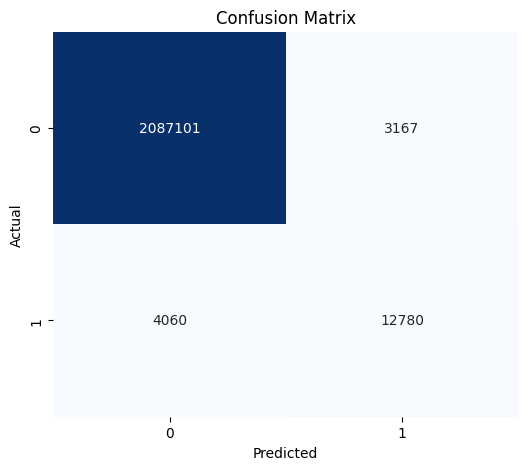

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, f1_score
import seaborn as sns
import matplotlib.pyplot as plt

y_pred_prob = final_model.predict(X_test)

threshold = 0.5
y_pred = [1 if p > threshold else 0 for p in y_pred_prob]


print("--- Test Set Evaluation ---")
print(classification_report(y_test, y_pred))

f1 = f1_score(y_test, y_pred)
print(f"F1 Score: {f1:.4f}")

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

We got recall score of 0.72 and precision of 0.85 on this model

The 3rd model we will check will be a NN model with 2 hidden layers with Relu as activation  function and output layer with sigmoid as activation fuinction for binary classification

In [ ]:
import pandas as pd
import numpy as np

def reduce_mem_usage(df):
    """ iterates through all the columns of a dataframe and modifies the data type
        to reduce memory usage.
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))

    for col in df.columns:
        col_type = df[col].dtype

        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
        else:
            num_unique_values = len(df[col].unique())
            num_total_values = len(df[col])
            if num_unique_values / num_total_values < 0.5:
                df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))

    return df

# שימוש:
df_wafers = reduce_mem_usage(df_wafers)

Memory usage of dataframe is 943.63 MB
Memory usage after optimization is: 486.87 MB
Decreased by 48.4%


In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.metrics import Recall, Precision, AUC
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.initializers import Constant
from tensorflow.keras import backend as K
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, fbeta_score
import gc

def train_high_precision_model(df_wafers):
    """
    Trains a Neural Network optimized for High Precision on imbalanced data.
    Uses Bias Initialization and F0.5 Score threshold tuning.
    """


    K.clear_session()
    gc.collect()


    if tf.config.list_physical_devices('GPU'):
        try:
            tf.config.experimental.set_memory_growth(tf.config.list_physical_devices('GPU')[0], True)
        except RuntimeError: pass


    feature_cols = [
        'IsGoodDie', 'HasBadNeighbor','SequenceLength','NumBadNeighbors_3x3',
        'NumBadNeighbors_5x5',"HasBadNeighbor_7x7","NumBadNeighbors_7x7",
        'HasBadNeighbor_5x5','BadDieWithBadNeighbor', 'ScratchScore', 'BadDieScore'
    ]


    df = df_wafers[feature_cols + ['IsScratchDie']].copy()


    for col in feature_cols:
        df[col] = pd.to_numeric(df[col], errors='coerce')


    df = df.fillna(0)


    X = df[feature_cols].values
    y = df['IsScratchDie'].values

    del df
    gc.collect()


    X_train_raw, X_test_raw, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    X_train_raw, X_val_raw, y_train, y_val = train_test_split(X_train_raw, y_train, test_size=0.25, random_state=42)


    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train_raw)
    X_val = scaler.transform(X_val_raw)
    X_test = scaler.transform(X_test_raw)


    del X_train_raw, X_val_raw, X_test_raw, X
    gc.collect()


    neg = len(y_train[y_train == 0])
    pos = len(y_train[y_train == 1])
    initial_bias = np.log([pos / neg])

    print(f"Computed Initial Bias: {initial_bias}")


    class_weight = {0: 1.0, 1: 5.0}
    print(f"Using Conservative Class Weights: {class_weight}")


    model = Sequential([
        Dense(32, activation='relu', input_shape=(X_train.shape[1],)),
        Dropout(0.3),
        Dense(16, activation='relu'),
        Dropout(0.3),

        Dense(1, activation='sigmoid', bias_initializer=Constant(initial_bias))
    ])

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss='binary_crossentropy',
        metrics=[Recall(name='recall'), Precision(name='precision'), AUC(name='auc')]
    )

    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=10,
        mode='min',
        restore_best_weights=True
    )


    print("Starting Training...")
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=50,
        batch_size=32,
        class_weight=class_weight,
        callbacks=[early_stopping],
        verbose=1
    )

    print("\nOptimizing Threshold for Precision (F0.5)...")
    val_preds_prob = model.predict(X_val)

    best_score = 0
    best_thresh = 0.5


    for thresh in np.arange(0.1, 0.96, 0.01):
        val_preds_binary = (val_preds_prob > thresh).astype(int)
        score = fbeta_score(y_val, val_preds_binary, beta=0.5)

        if score > best_score:
            best_score = score
            best_thresh = thresh

    print(f"Optimal Threshold Found: {best_thresh:.2f} (Val F0.5: {best_score:.4f})")

    print("\n--- Final Test Set Report ---")
    test_preds_prob = model.predict(X_test)
    test_preds_binary = (test_preds_prob > best_thresh).astype(int)

    print(classification_report(y_test, test_preds_binary))

    return model, best_thresh

model, threshold = train_high_precision_model(df_wafers)

Computed Initial Bias: [-4.85592221]
Using Conservative Class Weights: {0: 1.0, 1: 5.0}
Starting Training...


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
195289/195289 ━━━━━━━━━━━━━━━━━━━━ 569s 3ms/step - auc: 0.9873 - loss: 0.0406 - precision: 0.6587 - recall: 0.7286 - val_auc: 0.9908 - val_loss: 0.0161 - val_precision: 0.7485 - val_recall: 0.7780
Epoch 2/50
195289/195289 ━━━━━━━━━━━━━━━━━━━━ 557s 3ms/step - auc: 0.9910 - loss: 0.0344 - precision: 0.7287 - recall: 0.7702 - val_auc: 0.9914 - val_loss: 0.0147 - val_precision: 0.7564 - val_recall: 0.7761
Epoch 3/50
195289/195289 ━━━━━━━━━━━━━━━━━━━━ 594s 3ms/step - auc: 0.9906 - loss: 0.0347 - precision: 0.7274 - recall: 0.7654 - val_auc: 0.9898 - val_loss: 0.0137 - val_precision: 0.7894 - val_recall: 0.7595
Epoch 4/50
195289/195289 ━━━━━━━━━━━━━━━━━━━━ 558s 3ms/step - auc: 0.9902 - loss: 0.0352 - precision: 0.7232 - recall: 0.7640 - val_auc: 0.9931 - val_loss: 0.0162 - val_precision: 0.7582 - val_recall: 0.7746
Epoch 5/50
195289/195289 ━━━━━━━━━━━━━━━━━━━━ 559s 3ms/step - auc: 0.9899 - loss: 0.0352 - precision: 0.7348 - recall: 0.7615 - val_auc: 0.9907 - val_loss: 0.0136 - val

We can see that the LightGBM model and the NN model had very similar result but mothing with statistical significance so we'll stay with the lightgbm model